# Modele prédictif du prix des médicaments: Analyse descriptive du dataset

#### Methodologie:


I. Import des données  
II. Analyse descriptive: inlfuence des variables sur le prix des médicaments   
III. Text Analytics pour découvrir les fréquences et similiarités entre les médicaments  


<center><img src="http://pgxmed.com/wp-content/uploads/2014/03/drugsinhand.jpg" width="40%" height="40%"></center>

# I. Import des données

Chargement des packages:

In [1]:
import pandas as pd
import numpy as np
import unicodedata
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
# for interactive inline plots
#%matplotlib notebook  
# for simple inline plots
%matplotlib inline 
import seaborn as sns
import time, math
#from IPython.display import display

Chargement des données:

In [2]:
train = pd.read_csv('boites_medicaments_train.csv', encoding='utf-8', sep=';')
test = pd.read_csv('boites_medicaments_test.csv', encoding='utf-8', sep=';')

In [3]:
# convert all strings to lowercase and remove all accents, remove spaces
for i in list(train.select_dtypes(include=['object'])):
    # convert all strings to lowercase and remove all accents
    train[i] = train[i].str.lower().map(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'))
    test[i] = test[i].str.lower().map(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'))
    # removes space if it is first character
    train[i] = train[i].apply(lambda x : x[1:] if x[0]==' ' else x)    
    test[i] = test[i].apply(lambda x : x[1:] if x[0]==' ' else x)

# convert column name from string to unicode
train.rename(columns=lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'), inplace=True)
test.rename(columns=lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'), inplace=True)

Détails des champs du dataset:

- libelle : description du contenu de la boîte de médicament (exemple : 5 ampoules en verre de 5
ml)  
- libelle_xxx : 13 variables qui codent la présence de certains mots dans le libellé (exemple
- libelle_ampoule = 1 si le mot « ampoule » apparait dans le champs « libelle », 0 sinon.  
- nb_xxx : 14 variables qui indiquent certaines quantités présentes dans les libellés (exemple :
- nb_ampoule = 32 si « 32 ampoules » apparaît dans le champ « libelle », sinon 0  
- statut : statut administratif de la boîte de médicament  
- etat commerc : Etat de commercialisation de la boîte de médicament tel que déclaré par le
titulaire de l'AMM  
- agrement col : agrément aux collectivités ("oui", "non" ou « inconnu »)  
- tx rembours : taux de remboursement  
- forme pharma : forme pharmaceutique (comprimé pelliculé, comprimé sécable, …)  
- voies admin : voies d'administration (avec un séparateur « , » entre chaque valeur quand il y en a
plusieurs : orale, ophtalmique, intramusculaire, …)  
statut admin : statut administratif de l’autorisation de mise sur le marché (AMM) : active, abrogée,…  
- date déclar année : année de la déclaration de commercialisation de la boîte de médicament  
- date amm année : année d’Autorisation de Mise sur le Marché du médicament  
- type proc : Type de procédure d'autorisation de mise sur le marché (AMM) (Nationale,
décentralisée, reconnaissance mutuelle, …)  
- titulaires : laboratoire titulaire du médicament. S’il y a plusieurs titulaires, ils sont séparés par des
« , »  
- substances : substances présentes dans le médicament. S’il y en a plusieurs, elles sont séparées
par des « , »  
- prix : le prix de la boîte de médicament (présent dans le fichier « train » uniquement, à prédire
dans le fichier « test »

In [4]:
pd.set_option("display.max_columns", 999) 
train.head()

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix
0,3 plaquette(s) thermoformee(s) pvc-aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,presentation active,declaration de commercialisation,oui,65%,comprime pellicule,orale,autorisation active,2014,2014,procedure decentralisee,majorelle luxembourg soparfi (luxembourg),desogestrel,2.83
1,plaquette(s) thermoformee(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,presentation active,declaration de commercialisation,oui,65%,comprime a croquer,orale,autorisation active,2013,2009,procedure de reconnaissance mutuelle,teva sante,"montelukast acide, montelukast sodique",14.30
2,plaquette(s) thermoformee(s) pvc-aluminium de ...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0.0,presentation active,declaration de commercialisation,oui,65%,gelule a liberation prolongee,orale,autorisation active,2000,1996,procedure nationale,mylan sas,chlorhydrate de diltiazem,5.66
3,30 sachet(s)-dose(s) papier aluminium complexe...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0.0,presentation active,declaration de commercialisation,oui,65%,granules a liberation prolongee,orale,autorisation active,2005,2004,procedure nationale,sanofi aventis france,"acide valproique, valproate de sodium",24.27
4,plaquette(s) thermoformee(s) pvc-aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,presentation active,declaration d'arret de commercialisation,non,100%,comprime pellicule,orale,autorisation active,2015,2010,procedure nationale,teva sante,letrozole,59.94


In [5]:
pd.reset_option('display.max_columns')

# II. Analyse descriptive

### 1. Structure des datasets

Le dataset ```train``` comporte les caracteristiques et prix de 8564 boites de medicaments. C'est ce dataset que nous allons utiliser pour creer un modele.
Chaque boite de medicament est decrite par une observation de 41 variables. Ces variables sont decrites dans le fichier `Description.pdf`.

Le dataset ```test``` comporte les caracteristiques des 3671 boites de medicaments dont il faut predire le prix. A la difference de ```train```, le prix des boites de medicaments n'est bien sur pas inclus et une colonne `id` a ete ajoutée pour identifier les boites de medicaments pendant l'etape de soumission des predictions sur [Datascience.net](www.datascience.net)

In [6]:
def rstr(df): return df.shape, df.apply(lambda x: [len(x.unique()), x.unique()])   # useful to find unique values of categorical variables

rstr(train.append(test))

((12235, 42),
 agrement col                                           [2, [oui, non]]
 date amm annee       [40, [2014, 2009, 1996, 2004, 2010, 2000, 2001...
 date declar annee    [84, [2014, 2013, 2000, 2005, 2015, 2001, 2006...
 etat commerc         [4, [declaration de commercialisation, declara...
 forme pharma         [217, [comprime pellicule, comprime a croquer,...
 id                   [3672, [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0...
 libelle              [3145, [3 plaquette(s) thermoformee(s) pvc-alu...
 libelle_ampoule                                            [2, [0, 1]]
 libelle_capsule                                            [2, [0, 1]]
 libelle_comprime                                           [2, [1, 0]]
 libelle_film                                               [2, [0, 1]]
 libelle_flacon                                             [2, [0, 1]]
 libelle_gelule                                             [2, [0, 1]]
 libelle_pilulier                                 

Ainsi, nous groupons les variables par type (cela sera utile pour le feature engineering):
- Variables ordinales: tx rembours
- Variables catégorielles: agrement col, etat commerc, forme pharma, statut, statut admin, type proc
- Variables texte: libelle, substances, titulaires voies admin
- Variables numériques: reste des variables

### 2. Distribution des donnees

#### 2.1 Distribution du prix des medicaments

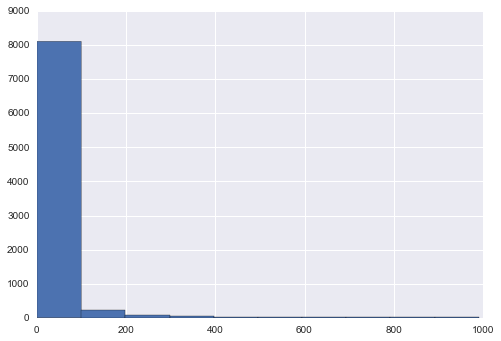

In [7]:
train['prix'].hist()

On prend le log des prix car sa distribution transformée est plus proche d'une gaussienne

count    8564.000000
mean        2.279071
std         1.271988
min        -0.510826
25%         1.371181
50%         2.071913
75%         3.002211
max         6.898099
Name: logprix, dtype: float64


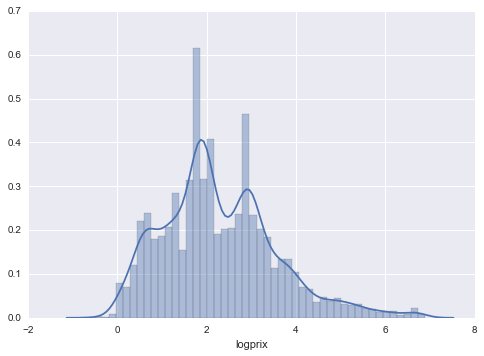

In [8]:
# Distribution du log des prix
train['logprix'] = train['prix'].apply(np.log)
#train['logprix'].hist()
sns.distplot(train['logprix'])
print train['logprix'].describe()

La distribution du log(prix) est bimodale: un pic principal a environ exp(1.8)=6 euros et un pic secondaire a environ exp(2.9)=18 euros.   
La moyenne de prix log est 2.27 et l'ecart type est 1.27.

#### 2.2 Visualizing pairwise relationship between features

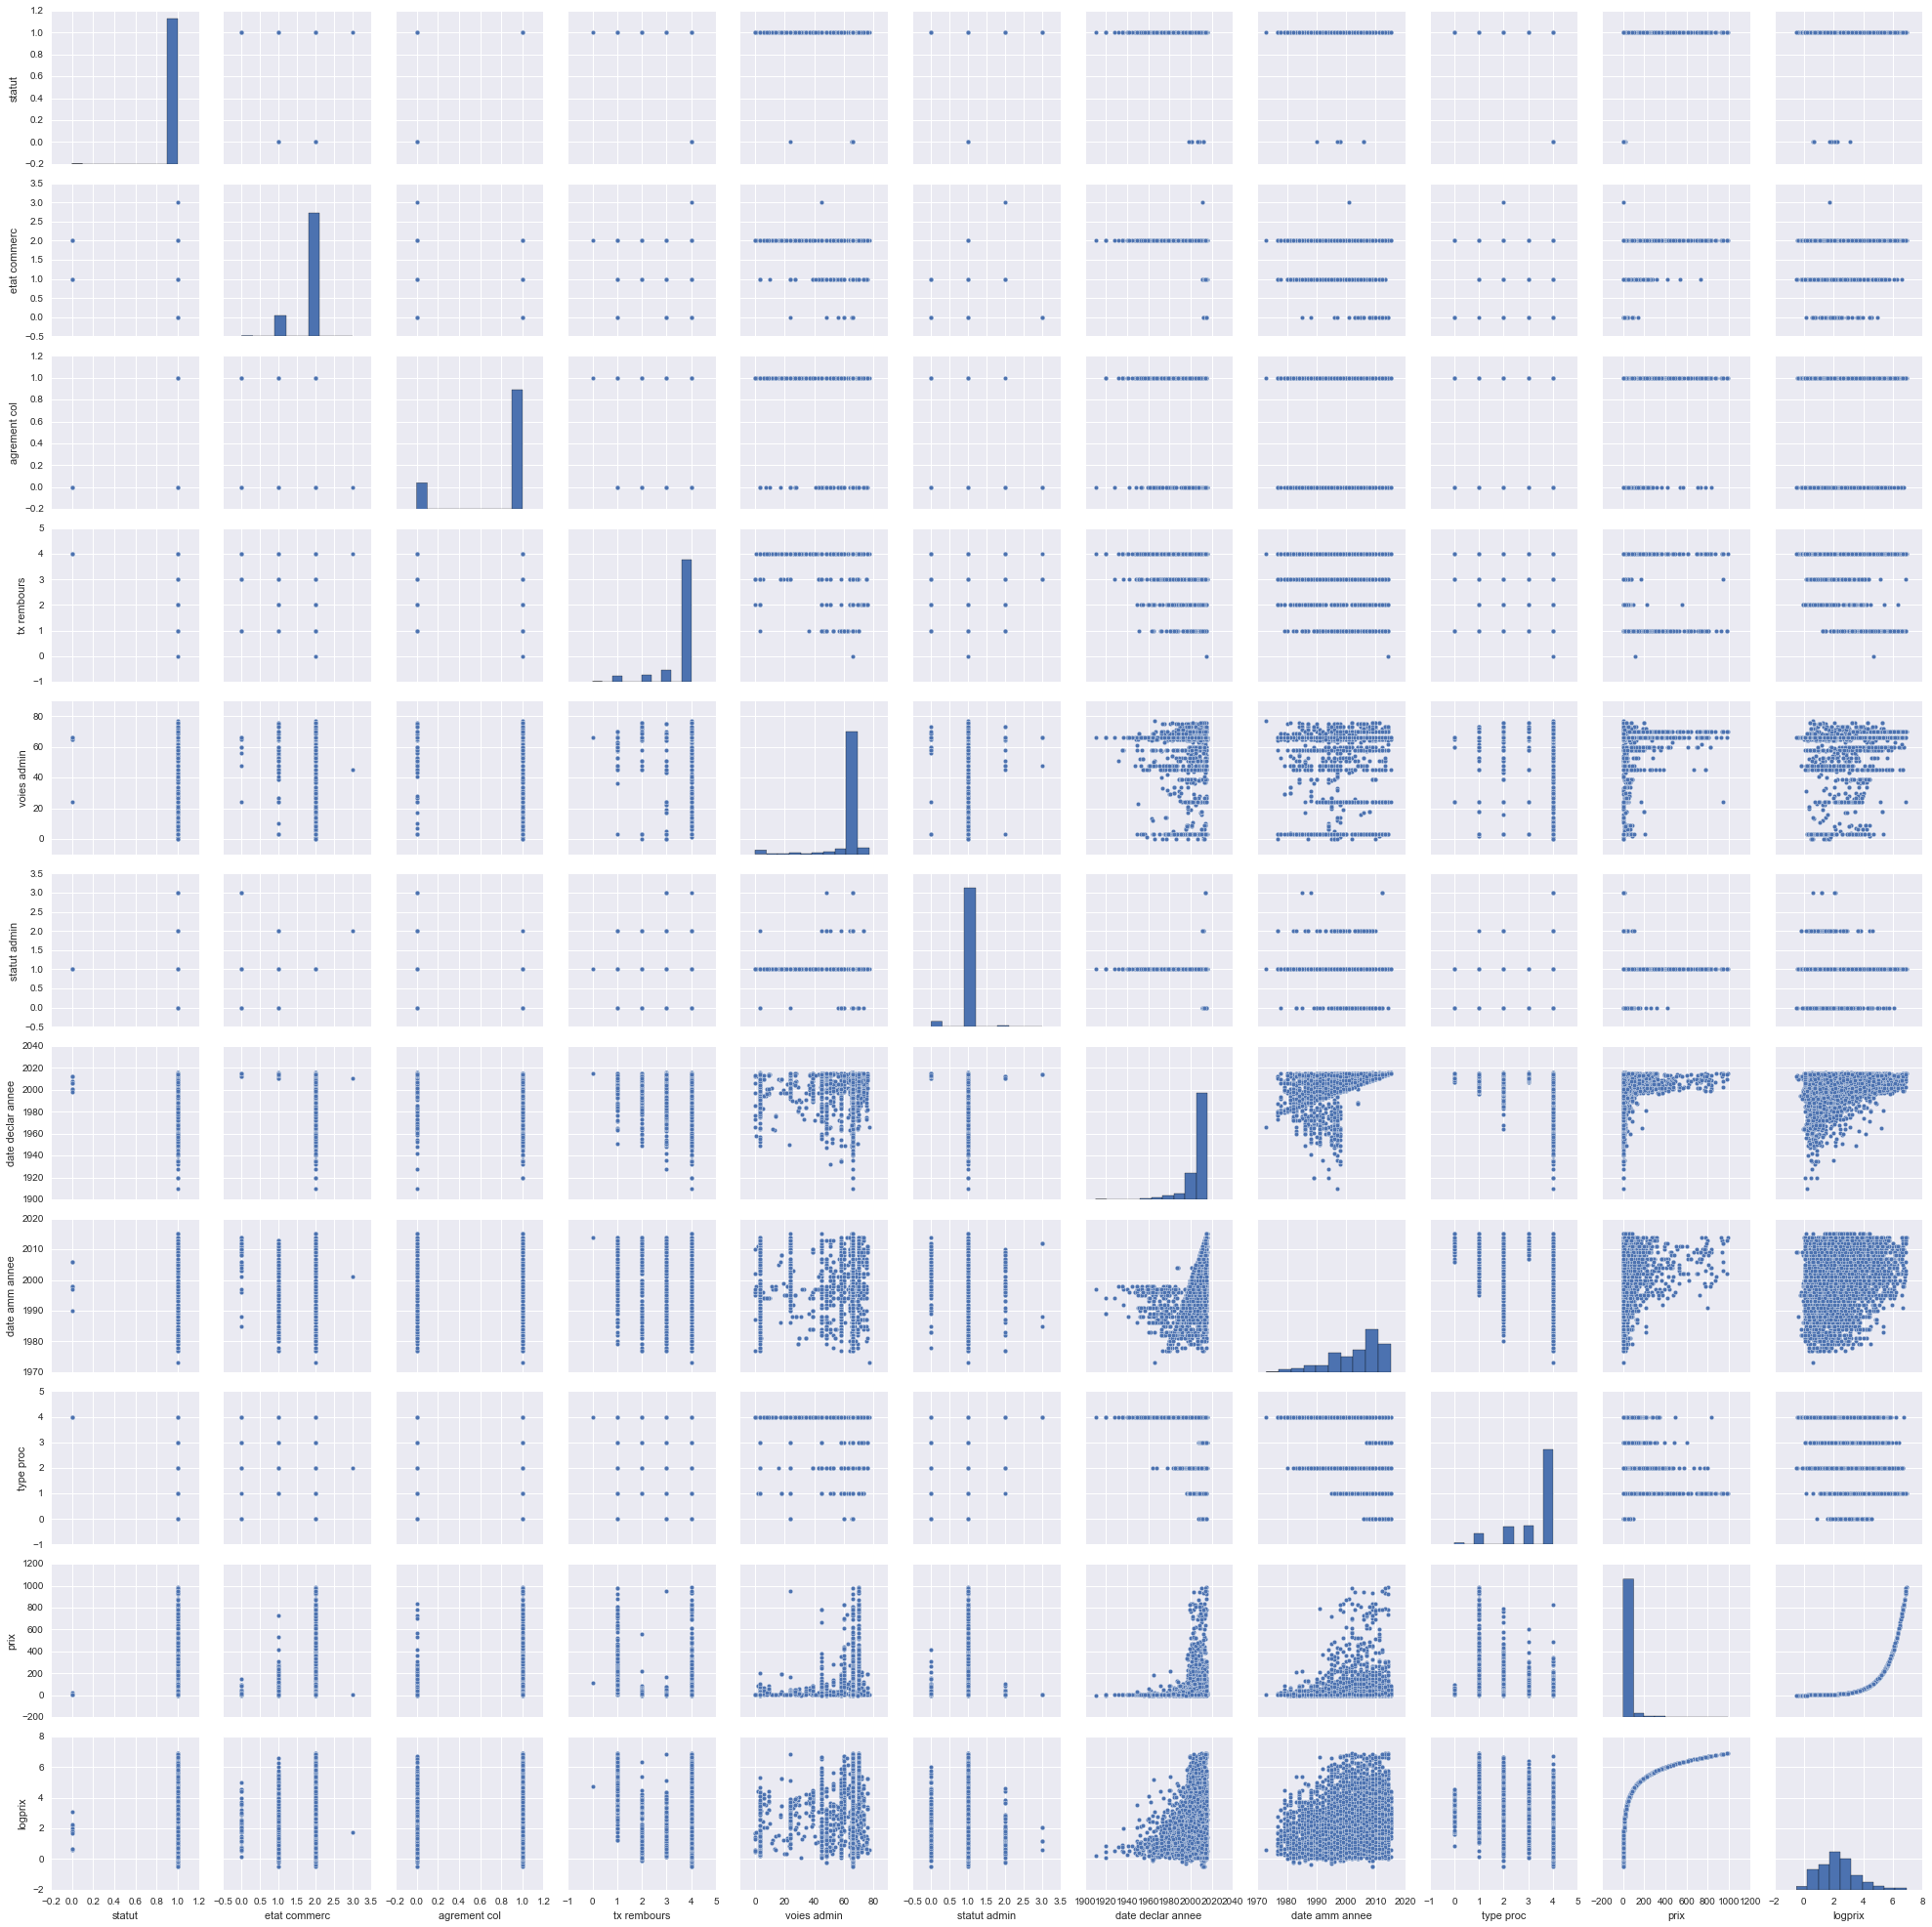

In [93]:
sns.pairplot( train.drop(feat_num+feat_text, axis = 1)  )

#### 2.3 Identification des outliers

##### Prix

Pour le prix, on peut considerer que les medicaments avec un ecart à la moyenne de plus de 3 SD sont des outliers.  
Rappel: La moyenne de prix log est 2.27 et l'ecart type est 1.27.   
Identifions-les de cette facon:

In [220]:
condition = (train['logprix'] <= 2.27 - 3 * 1.27)
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1     # flag them as outliers

6      877.83
109    779.30
229    694.71
272    759.48
522    665.11
Name: prix, dtype: float64


In [221]:
condition = (train['logprix'] >= 2.27 + 3 * 1.27)
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1     # flag them as outliers

6      877.83
109    779.30
229    694.71
272    759.48
522    665.11
Name: prix, dtype: float64


##### Statut

In [222]:
condition = (train['statut'] == 'presentation abrogee')
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1    # flag them as outliers

6      877.83
109    779.30
229    694.71
272    759.48
522    665.11
Name: prix, dtype: float64


##### Etat commerc

In [226]:
condition = ((train['etat commerc'] == "arret de commercialisation (le medicament n'a plus d'autorisation)") | 
                       (train['etat commerc'] == 'declaration de suspension de commercialisation'))
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1    # flag them as outliers

6      877.83
109    779.30
229    694.71
272    759.48
522    665.11
Name: prix, dtype: float64


In [ ]:
condition = (train['statut'] == 'presentation abrogee')
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1    # flag them as outliers

##### Tx Rembours

In [211]:
condition = (train['tx rembours'] == '0%')
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1    # flag them as outliers

390    112.22
Name: prix, dtype: float64


##### Statut admin

In [223]:
condition = (train['statut admin'] == 'autorisation retiree')
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1    # flag them as outliers

6      877.83
109    779.30
229    694.71
272    759.48
522    665.11
Name: prix, dtype: float64


##### Date declar annee

476    1.72
551    1.66
567    2.14
708    1.48
942    2.03
Name: prix, dtype: float64


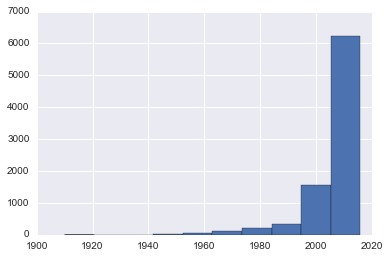

In [227]:
train['date declar annee'].hist()
condition = (train['date declar annee'] <= 1950)
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1    # flag them as outliers

##### Date amm annee

38      1.69
152    11.92
241     2.60
518    34.17
532     1.45
Name: prix, dtype: float64


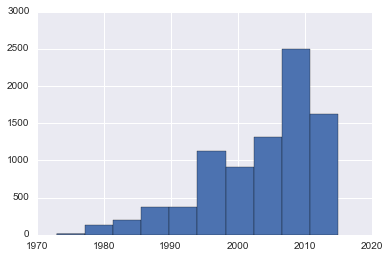

In [228]:
train['date amm annee'].hist()
condition = (train['date amm annee'] <= 1980)
print train['prix'][ condition ].head()
train.loc[ condition , 'outliers'] = 1    # flag them as outliers

##### Synthese et representation graphique des outliers

In [232]:
train['outliers'].value_counts(normalize=True)

0    0.968589
1    0.031411
Name: outliers, dtype: float64

Nous avons identifié 3.1% d'outliers, representés en rouge ci-dessous:

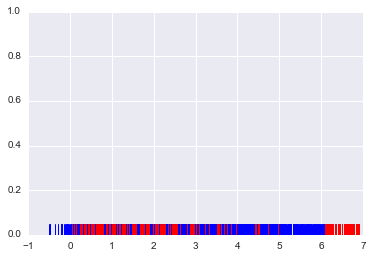

In [229]:
ax = sns.rugplot(train['logprix'])
sns.rugplot(train['logprix'][ train['outliers'] == 1 ], ax=ax, color='red')

Export de l' ID des medicaments consideres comme outliers (pour utilisation future dans le modele predictif, si besoin):

In [9]:
#train['outliers'].to_csv('outliers.csv', index=True, header=['outliers'], sep = ';')

### 3. Influence des differentes variables sur le prix

#### 3.1 Visualizing relationship between log(prix) and 'date AMM'

<IPython.core.display.Javascript object>


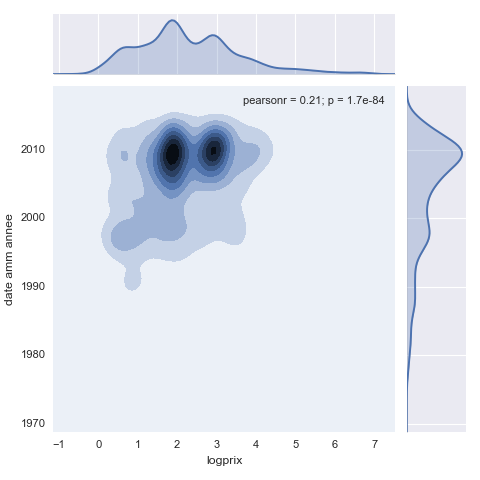

count    8564.000000
mean     2003.521952
std         8.212770
min      1973.000000
25%      1998.000000
50%      2006.000000
75%      2010.000000
max      2015.000000
Name: date amm annee, dtype: float64

In [81]:
sns.jointplot(x="logprix", y="date amm annee", data=train, kind="kde")
#train['date amm annee'].describe()

La grande majorite des medicaments du dataset ont recu leur Autorisation de Mise sur le Marché en 2006 (mediane), avec un pic en 2010.

#### 3.2 Visualizing relationship between log(prix) and 'date declar annee'

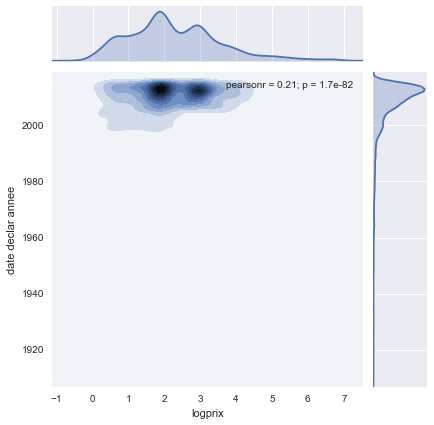

In [96]:
sns.jointplot(x="logprix", y="date declar annee", data=train, kind="kde")

La grande majorite des medicaments du dataset ont eu leur declaration de mise sur le marche deposée en 2010 (mediane), avec un pic en 2013.

#### 3.3 Influence du taux de remboursement sur le prix

4    0.837809
3    0.076600
2    0.045890
1    0.039584
0    0.000117
Name: tx rembours, dtype: float64

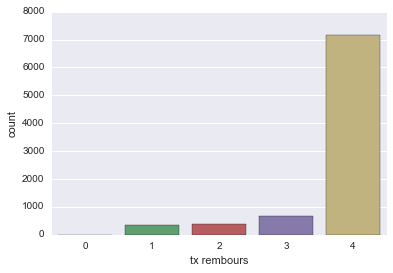

In [417]:
sns.countplot(x="tx rembours", data=train)
train['tx rembours'].value_counts(normalize=True) # proportion

La grande majorité des medicaments (83%) sont remboursés à 65%.

1    0.819944
0    0.180056
Name: agrement col, dtype: float64

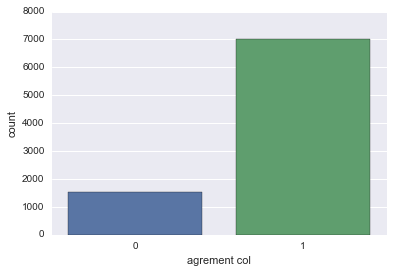

In [416]:
sns.countplot(x="agrement col", data=train)
train['agrement col'].value_counts(normalize=True) # proportion

La grande majorité des medicaments (81%) ont recu l'agrement des collectivités (ie remboursement par la SS)

Moyenne du prix, groupée par taux de remboursement :
                   mean
tx rembours            
0%           112.220000
100%         179.026342
15%           13.904326
30%            8.406845
65%           24.049047

Moyenne du log(prix), groupée par taux de remboursement :
                   mean
tx rembours            
0%           112.220000
100%          93.125669
15%            6.186883
30%            4.020264
65%            9.760745


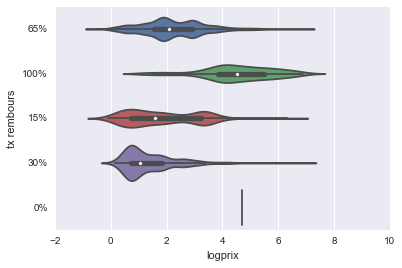

In [155]:
sns.violinplot(x="logprix", y="tx rembours", data=train)
print 'Moyenne du prix, groupée par taux de remboursement :'
print train.groupby('tx rembours')['prix'].agg([np.mean])
print 
print 'Moyenne du log(prix), groupée par taux de remboursement :'
print np.exp( train.groupby('tx rembours')['logprix'].agg([np.mean]) )

La moyenne de prix pour les medicaments remboursés à 100% est la plus elevée (179 euros), mais ne concerne que 4% des médicaments, comme vu plus haut.
La moyenne de prix pour les medicaments remboursés à 65% est de 8 euros, ce qui concerne environ 84% des medicaments.

##### Role de 'agrement col' dans le log(prix) des medicaments remboursés à 65% :

oui    0.814634
non    0.185366
Name: agrement col, dtype: float64


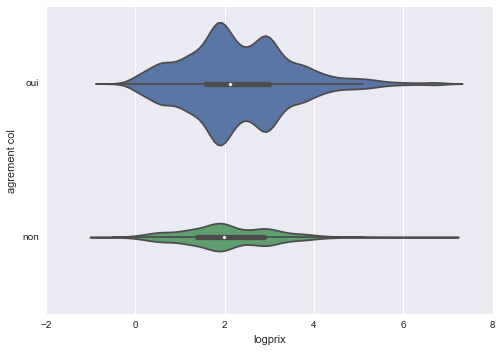

In [11]:
# Distribution de log(prix) en fonction de 'agrement col', pour tous les médicaments avec un remboursement de 65%
train65 = train[ train['tx rembours'] == '65%']
sns.violinplot(x="logprix", y="agrement col", #hue="agrement col", 
               split=True, scale="count", 
               data= train65)  

print train65['agrement col'].value_counts(normalize=True) # proportion

La grande majorité (81%) des médicaments remboursés à 65% ont reçu l'agrément aux collectivités.

##### Role de 'statut admin' dans le log(prix) des medicaments remboursés à 65% :

Autorisation active      0.952195
Autorisation abrogée     0.039721
Autorisation archivée    0.007944
Autorisation retirée     0.000139
Name: statut admin, dtype: float64


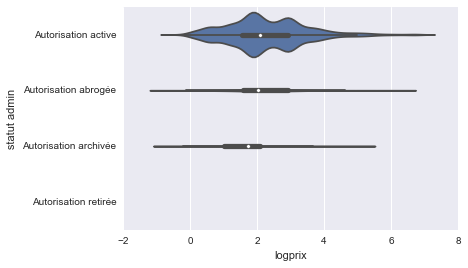

In [413]:
# Distribution de log(prix) en fonction de 'statut admin', pour tous les médicaments avec un remboursement de 65%
sns.violinplot(x="logprix", y="statut admin", #hue="agrement col", 
               split=True, scale="count", 
               data= train65)  

print train65['statut admin'].value_counts(normalize=True) # proportion

La grande majorité (95%) des médicaments remboursés à 65% ont une autorisation active.

##### Role de 'statut' dans le log(prix) des medicaments remboursés à 65% :

Présentation active     0.998606
Présentation abrogée    0.001394
Name: statut, dtype: float64


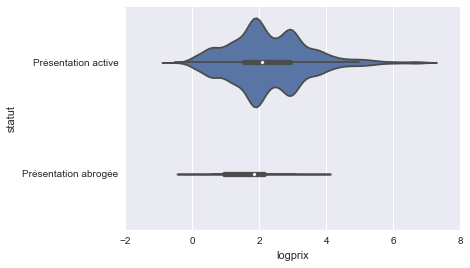

In [412]:
# Distribution de log(prix) en fonction de 'statut', pour tous les médicaments avec un remboursement de 65%
sns.violinplot(x="logprix", y="statut", #hue="agrement col", 
               split=True, scale="count", 
               data= train65)  

print train65['statut'].value_counts(normalize=True) # proportion

La grande majorité (99%) des médicaments remboursés à 65% ont une présentation active.

##### Role de 'etat commerc' dans le log(prix) des medicaments remboursés à 65% :

Déclaration de commercialisation                                      0.841533
Déclaration d'arrêt de commercialisation                              0.152892
Arrêt de commercialisation (le médicament n'a plus d'autorisation)    0.005436
Déclaration de suspension de commercialisation                        0.000139
Name: etat commerc, dtype: float64


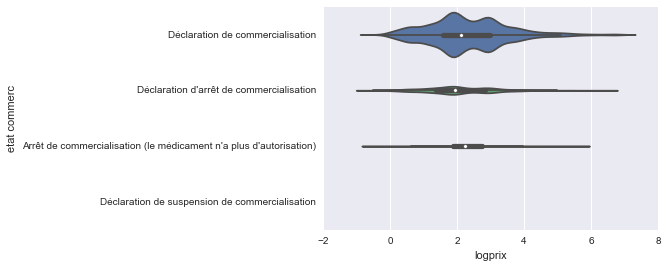

In [411]:
# Distribution de log(prix) en fonction de 'etat commerc', pour tous les médicaments avec un remboursement de 65%
sns.violinplot(x="logprix", y="etat commerc", #hue="agrement col", 
               split=True, scale="count", 
               data= train65)  

print train65['etat commerc'].value_counts(normalize=True) # proportion

La grande majorité (84%) des médicaments remboursés à 65% ont une Déclaration de commercialisation.
Et 15% ont une Déclaration d'arrêt de commercialisation.

#### 3.4 Influence du type de procédure sur le prix du médicament

Type de procédure d'autorisation de mise sur le marché (AMM) (Nationale, décentralisée, reconnaissance mutuelle, …)

Procédure nationale                     0.655068
Procédure décentralisée                 0.130780
Procédure de reconnaissance mutuelle    0.123540
Procédure centralisée                   0.078234
Autorisation d'importation parallèle    0.012377
Name: type proc, dtype: float64

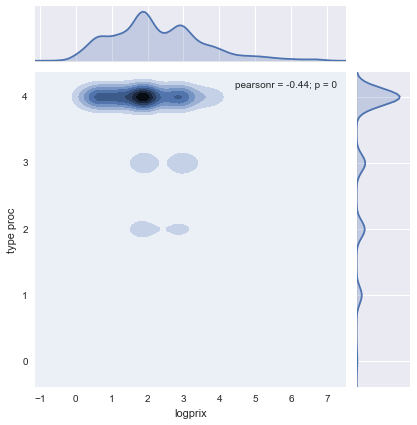

In [410]:
sns.jointplot(x="logprix", y="type proc", data=train, kind="kde")

train2 = pd.read_csv('boites_medicaments_train.csv', encoding='utf-8', sep=';')
train2['logprix'] = train2['prix'].apply(np.log)
train2['type proc'].value_counts(normalize=True) # proportion

Concernant l'autorisation de mise sur le marché, la procedure nationale est la plus courante (65% des medicaments). Suivie de la procedure décentralisée (13%) et de reconnaissance mutuelle (12%).

#### 3.5 Influence du titulaire (laboratoire) sur le prix du médicament

In [6]:
# Nombre de titulaire par medicament 
train['titulaires_nb'] = train['titulaires'].apply(lambda x:  len(x.split(','))    ).astype(int) 
train['titulaires_nb'].value_counts()

1    8562
2       2
Name: titulaires_nb, dtype: int64

Chaque médicament (chaque ligne du dataset) a un seul et unique titulaire.  

##### Quels sont les 5 titulaires les moins chers, les plus chers? (tous médicaments confondus)

In [7]:
print "5 titulaires vendant les medicaments les moins chers :"
titul_sort = train.sort_values('prix', ascending=True)[['titulaires','prix']]
print titul_sort.head(5)
print
print "5 titulaires vendant les medicaments les plus chers :"
titul_sort = train.sort_values('prix', ascending=False)[['titulaires','prix']]
print titul_sort.head(5)

5 titulaires vendant les medicaments les moins chers :
                                            titulaires  prix
8330                            RATIOPHARM (ALLEMAGNE)  0.60
2096                                          BIOGARAN  0.62
1561                            RATIOPHARM (ALLEMAGNE)  0.62
2922                                       MERCK SANTE  0.69
910    ASSISTANCE PUBLIQUE - HOPITAUX DE PARIS - AP-HP  0.75

5 titulaires vendant les medicaments les plus chers :
                                          titulaires    prix
5016                              ROCHE REGISTRATION  990.39
5367                                    AMGEN EUROPE  979.08
6190     GILEAD SCIENCES INTERNATIONAL (ROYAUME-UNI)  977.09
6745    FOREST LABORATORIES UK LIMITED (ROYAUME-UNI)  948.28
8556   BRISTOL MYERS SQUIBB PHARMA (GRANDE BRETAGNE)  947.88


##### Quels sont les 5 titulaires les moins chers, les plus chers? (pour les médicaments remboursés à 65%)

In [12]:
print "5 titulaires vendant les medicaments les moins chers :"
titul_sort = train65.sort_values('prix', ascending=True)[['titulaires','prix']]
print titul_sort.head(5)
print
print "5 titulaires vendant les medicaments les plus chers :"
titul_sort = train65.sort_values('prix', ascending=False)[['titulaires','prix']]
print titul_sort.head(5)

5 titulaires vendant les medicaments les moins chers :
                                            titulaires  prix
8330                            RATIOPHARM (ALLEMAGNE)  0.60
1561                            RATIOPHARM (ALLEMAGNE)  0.62
2096                                          BIOGARAN  0.62
2922                                       MERCK SANTE  0.69
910    ASSISTANCE PUBLIQUE - HOPITAUX DE PARIS - AP-HP  0.75

5 titulaires vendant les medicaments les plus chers :
                                          titulaires    prix
5016                              ROCHE REGISTRATION  990.39
8556   BRISTOL MYERS SQUIBB PHARMA (GRANDE BRETAGNE)  947.88
3681                            ABBVIE (ROYAUME-UNI)  940.61
6288                            ABBVIE (ROYAUME-UNI)  940.61
6948                    JANSSEN BIOLOGICS (PAYS-BAS)  934.11


Dans les titulaires les moins chers, on retrouve principalement les generiqueurs (Biogaran, Ratiopharm...). Pour les titulaires les plus chers, on retrouve principalement les laboratoires innovateurs (Roche, Abbvie...). Note: une analyse plus detaillée pourrait prendre en compte le packaging (nombre de gelules par boîte...).

#### 3.6 Influence des susbtances (molécules) sur le prix du médicament

1     4940
2     3114
3      236
4      172
5       41
6       16
27       8
30       6
31       4
23       4
8        4
29       4
34       3
10       3
9        2
7        2
11       2
28       1
25       1
17       1
Name: substances_nb, dtype: int64
1     0.576833
2     0.363615
3     0.027557
4     0.020084
5     0.004787
6     0.001868
27    0.000934
30    0.000701
31    0.000467
23    0.000467
8     0.000467
29    0.000467
34    0.000350
10    0.000350
9     0.000234
7     0.000234
11    0.000234
28    0.000117
25    0.000117
17    0.000117
Name: substances_nb, dtype: float64


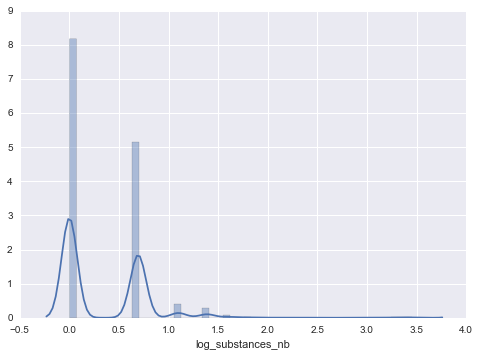

In [16]:
# Nombre de titulaire par medicament et proportion
train['substances_nb'] = train['substances'].apply(lambda x:  len(x.split(','))    ).astype(int)  
print train['substances_nb'].value_counts()
print train['substances_nb'].value_counts(normalize=True)  # proportion

train['log_substances_nb'] = train['substances_nb'].apply(np.log)
sns.distplot(train['log_substances_nb'])

57% des medicaments sont composés de 1 seule 'substance' (molecule active).  
36% des medicaments sont composés de 2 molecules actives.  
4% des medicaments sont composés de 3 ou 4 molecules actives.

##### Influence du log(nombre de substances) sur le log(prix) du médicament:

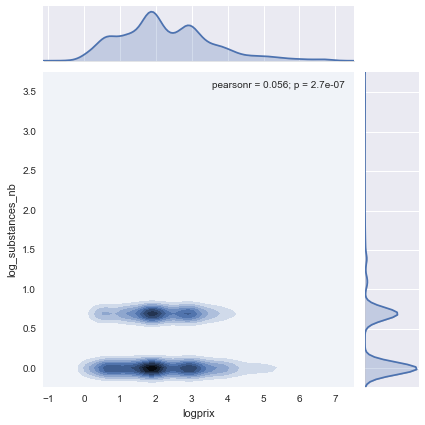

In [198]:
sns.jointplot(x="logprix", y="log_substances_nb", data=train, kind="kde")

On peut en deduire que le log du nombre de substances dans le medicament (log_substances_nb) pourrait etre une feature interessante (en terme de pouvoir predictif).

# III. Text Analytics pour trouver des similiarités entre les médicaments

Quelles sont les substances les plus courantes? Les plus rares? Idem pour les laboratoires.  
Est-ce possible de grouper les médicaments par similiarités? (selon leurs laboratoires et leurs molécules actives)

Extracting features from text files: 

- In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors. See http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html.

- Creating a document-term matrix for the 'substances' feature: Converts data into counts, and then can be fed to the learning algorithm. See: http://scikit-learn.org/stable/modules/feature_extraction.html


## 1. Document-term matrix for the 'substances'

L'approche typique est l'utilisation d'un 'Vectorizer'. CountVectorizer tokenizes and counts the word occurrences:
- Each term found by the analyzer during the fit is assigned a unique integer index corresponding to a column in the resulting matrix. 
- Values of this matrix represent the count of word occurrence.

| dtm           | ...           | col_346 (desogestrel)  |  ... | 
| --- |  :---:  :---:       | :---: |
| Drug #0      |  ... | 1  | ... |
| ...      | ... |      ...      |   ... |
| Drug #m | ... | ...     |  ... |

For example, the first row of the dtm matrix shows a '1' at the 346th column, which is associated to the word 'desogestrel', 
per the vocabulary list. In other words, the element (0,346) of the dtm matrix equals to 1, which means that the word 'desogestrel' appears 1 time in the first row of 'substances'.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(encoding='utf-8', strip_accents='ascii', lowercase=True)
dtm_sparse = count_vect.fit_transform(train['substances'])     # (sparse) document-term matrix
vocab_list = count_vect.get_feature_names()                      # vocabulary list (list of unique words)

# converts to (dense) numpy arrays:
dtm = dtm_sparse.toarray() 
vocab = np.array(vocab_list)

print dtm.shape
print 'Document term matrix:'
print dtm[50:60]  
print
print 'Vocabulary list:'
print vocab[50:60]

(8564L, 1295L)
Document term matrix:
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

Vocabulary list:
[u'acetylsalicylate' u'acetylsalicylique' u'aciclovir' u'acide' u'acides'
 u'acitretine' u'actif' u'adalimumab' u'adapalene' u'adefovir']


The index value of a word in the vocabulary is linked to its frequency in the whole training corpus:

In [34]:
print 'Frequency of *desogestrel* in the whole training corpus (all drugs) =', count_vect.vocabulary_.get(u'desogestrel') 
print
print 'Frequency of *desogestrel* in Drug #0 (1st row of dtm) =', dtm[0].tolist()[346]  
print
# Once fitted, the vectorizer has built a dictionary of feature indices:
desogestrel_idx = count_vect.vocabulary_.get(u'desogestrel')   # or list(vocab).index('desogestrel') 
print 'Frequency of *desogestrel* in Drug #0 (1st row of dtm) =', dtm[0, desogestrel_idx]   #or dtm[0, vocab == 'desogestrel']
print
print 'Frequency of *acetylsalicylate* in Drug #0 (1st row of dtm) =', dtm[0, vocab == 'acetylsalicylate']

Frequency of *desogestrel* in the whole training corpus (all drugs) = 346

Frequency of *desogestrel* in Drug #0 (1st row of dtm) = 1

Frequency of *desogestrel* in Drug #0 (1st row of dtm) = 1

Frequency of *acetylsalicylate* in Drug #0 (1st row of dtm) = [0]


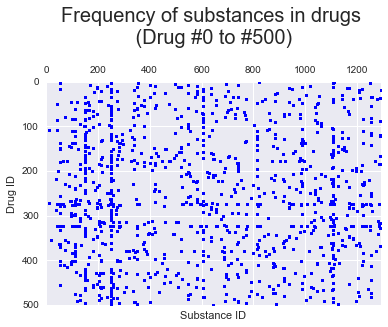

In [440]:
plt.spy(dtm[0:500], precision=0, markersize=3, aspect='auto')   # Plot the sparsity pattern of a 2-D array
plt.title('Frequency of substances in drugs \n (Drug #0 to #500) \n', fontsize=20)
plt.xlabel('Substance ID')
plt.ylabel('Drug ID')
plt.show()

## 2. Tf–idf term matrix for the 'substances'

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. 'tf–idf' means **term-frequency times inverse document-frequency**. This was originally a term weighting scheme developed for information retrieval. Term frequency-inverse document frequency (TF-IDF) is a feature vectorization method widely used in text mining to **reflect the importance of a term to a document in the corpus**.

TF: On a large document the frequency of the terms will be much higher than the smaller ones. Hence we need to normalize the document based on its size. A simple trick is to divide the term frequency by the total number of terms.  

For example in Document 1 the term game occurs two times. The total number of terms in the document is 10.    
ex.: IDF('game') = 1 + loge(Total Number Of Documents / Number Of Documents with term 'game' in it)

**TFIDF = TF * IDF**

TfidfVectorizer combines all the options of CountVectorizer and TfidfTransformer in a single model:

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(encoding='utf-8', strip_accents='ascii', lowercase=True)

# no need to normalize, since Vectorizer will return normalized tf-idf
tfidf_sparse = tfidf_vect.fit_transform(train['substances'])
vocab_list = tfidf_vect.get_feature_names()                      # vocabulary list (list of unique words)
vocab_list = np.array([s.encode('ascii') for s in vocab_list])   # convert unicode to string

# convert sparse matrix to dense:
tfidf = tfidf_sparse.toarray()
print 'tf-idf matrix for *substances*:'
print tfidf
print tfidf.shape
print
print 'Frequency of *desogestrel* in Drug #0 (1st row of tfidf), over its frequency in all drugs =', tfidf[0, np.where(vocab_list == 'desogestrel')]

tf-idf matrix for *substances*:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(8564L, 1295L)

Frequency of *desogestrel* in Drug #0 (1st row of tfidf), over its frequency in all drugs = [[ 1.]]


## 3. Similarity between drugs

With the tf-idf matrix in hand, we can easily compute the cosine similarities between drugs:

In [84]:
pairwise_similarity = tfidf_sparse * tfidf_sparse.T  # element-wise matrix multiplication
pairwise_similarity = pairwise_similarity.toarray()  # convert scipy sparse matrix to numpy array
print 'Cosine pairwise similarity:'
print pairwise_similarity     
print
print 'Cosine similarity between drug #10 and drug #79:', pairwise_similarity[10,79]

Cosine pairwise similarity:
[[ 1.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          1.          0.         ...,  0.07554767  0.          0.        ]
 [ 0.          0.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.07554767  0.         ...,  1.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          1.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          1.        ]]

Cosine similarity between drug #10 and drug #78: 0.0


Note: Measures of distance can be converted into measures of similarity. If your measures of distance are all between zero and one, then a measure of similarity could be one minus the distance. (The inverse of the distance would also serve as a measure of similarity.)

#### Clustering texts based on distance: DBSCAN clustering

Any clustering of texts should result in texts that are closer to each other (in the distance matrix) residing in the same cluster. There are many ways of satisfying this requirement; there no unique clustering based on distances that is the “best”. Here we are using the DBSCAN clustering algorithm to group similar drugs together. For more details, see the 'predictive model' file.

## 4. Frequency of sustances present in drugs of the training dataset

Quelles sont les substances les moins frequents dans les medicaments du dataset ? les substances les plus frequentes ?

In [87]:
subs_freq = pd.DataFrame(data = tfidf.sum(axis=0),
                         columns=['freq'],
                         index = [range(0, tfidf.shape[1])])

vocab_freq = pd.DataFrame(data = np.array(vocab_list),
                          columns=['term'],
                          index = [range(0, dtm.shape[1])])

term_freq = subs_freq.join(vocab_freq)

print "Les 5 substances les moins frequents dans les medicaments du dataset :"
subst_sort = term_freq.sort_values('freq', ascending=True) 
print subst_sort.head()
print
print "Les 10 substances les plus frequents dans les medicaments du dataset :"
subst_sort = term_freq.sort_values('freq', ascending=False) 
print subst_sort.head(10)

Les 5 substances les moins frequents dans les medicaments du dataset :
          freq      term
0     0.086298        11
8     0.086298        18
1278  0.095036      w135
200   0.098297        bx
1266  0.098297  victoria

Les 10 substances les plus frequents dans les medicaments du dataset :
            freq                 term
335   497.146266                   de
248   341.711945         chlorhydrate
621   233.552869  hydrochlorothiazide
1118  198.858052              sodique
149   177.232749                 base
1258  153.554432            valsartan
131   122.097540        atorvastatine
672   117.981741           irbesartan
949   110.876257          perindopril
110   110.250067              anhydre


## 5. Frequency of 'titulaires' in the training dataset

Since each drug can have only one 'titulaire' (except for 2 drugs which have 2 titulaires), the frequency of 'titulaires' can be computed as follows:

In [90]:
print "Les 5 titulaires les moins frequents du dataset :"
print train['titulaires'].value_counts(normalize=True, ascending=True).head(5)
print
print "Les 20 titulaires les plus frequents du dataset :"
print train['titulaires'].value_counts(normalize=True).head(5)

Les 5 titulaires les moins frequents du dataset :
 ACINO PHARMA (ALLEMAGNE)                   0.000117
 ALK ABELLO (DANEMARK)                      0.000117
 BIOPROJET EUROPE (IRLANDE)                 0.000117
 IONFARMA (ESPAGNE)                         0.000117
 PROCTER & GAMBLE PHARMACEUTICALS FRANCE    0.000117
Name: titulaires, dtype: float64

Les 20 titulaires les plus frequents du dataset :
 TEVA SANTE               0.090729
 SANOFI AVENTIS FRANCE    0.066674
 MYLAN SAS                0.066207
 BIOGARAN                 0.057917
 SANDOZ                   0.053246
Name: titulaires, dtype: float64
